In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sklearn

In [2]:
bits = pd.read_csv('coinbaseUSD_1-min_data_2014-12-01_to_2019-01-09.csv')
bits.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1417411980,300.0,300.0,300.0,300.0,0.01,3.0,300.0
1,1417412040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1417412100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1417412160,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1417412220,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We will be using weighted price of bitcoin for prediction. Currently the time is in unix timestamp and has data for every minute. Lets average the price over a day and forecast for next 30 days.

In [3]:
bits['date'] = pd.to_datetime(bits['Timestamp'],unit='s').dt.date
group = bits.groupby('date')
Real_Price = group['Weighted_Price'].mean()

In [4]:
Real_Price[0:5]

date
2014-12-01    335.000000
2014-12-02    377.854911
2014-12-03    377.818333
2014-12-04    377.100000
2014-12-06    378.000000
Name: Weighted_Price, dtype: float64

In [5]:
# split data
prediction_days = 30
df_train= Real_Price[:len(Real_Price)-prediction_days]
df_test= Real_Price[len(Real_Price)-prediction_days:]

## One Shot LSTM/RNN

In [6]:
# hyperparameters
n_steps = 10
nb_epochs=20
lr=0.001

In [7]:
# Data preprocess
training_set = df_train.values
training_set = np.reshape(training_set, (len(training_set), 1))
test_set = df_test.values
test_set = np.reshape(test_set, (len(test_set), 1))
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
training_set = sc.fit_transform(training_set)
test_set = sc.transform(test_set)

In [8]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [9]:
#Prepare batches bs*seq_len*1
X_train,y_train = split_sequence(training_set, n_steps)
print(X_train.shape)
print(len(test_set))
X_test, y_test = split_sequence(test_set, n_steps)
print(X_test.shape)

(1425, 10, 1)
30
(20, 10, 1)


In [10]:
import tensorflow as tf

In [11]:
mc = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [12]:
# define model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(50, activation='relu', input_shape=(n_steps, 1)))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mse')

In [13]:
model.fit(X_train, y_train, epochs=nb_epochs, verbose=1, validation_data=(X_test, y_test),callbacks=[mc, es])

Train on 1425 samples, validate on 20 samples
Epoch 1/20
1425/1425 [==============================] - 7s 5ms/step - loss: 0.0178 - val_loss: 2.1389e-04

Epoch 00001: saving model to best_model.h5
Epoch 2/20
1425/1425 [==============================] - 1s 954us/step - loss: 6.6590e-04 - val_loss: 2.3074e-04

Epoch 00002: saving model to best_model.h5
Epoch 3/20
1425/1425 [==============================] - 1s 965us/step - loss: 5.2283e-04 - val_loss: 2.3357e-04

Epoch 00003: saving model to best_model.h5
Epoch 4/20
1425/1425 [==============================] - 1s 930us/step - loss: 4.7647e-04 - val_loss: 1.2014e-04

Epoch 00004: saving model to best_model.h5
Epoch 5/20
1425/1425 [==============================] - 1s 928us/step - loss: 4.5306e-04 - val_loss: 1.0341e-04

Epoch 00005: saving model to best_model.h5
Epoch 6/20
1425/1425 [==============================] - 1s 925us/step - loss: 4.4146e-04 - val_loss: 1.2014e-04

Epoch 00006: saving model to best_model.h5
Epoch 7/20
1425/1425 [==

In [14]:
# load the saved model
saved_model = tf.keras.models.load_model('best_model.h5')
# evaluate the model
train_loss = saved_model.evaluate(X_train, y_train, verbose=0)
test_loss = saved_model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_loss, test_loss))

Train: 0.000, Test: 0.000


## Inference

In [15]:
train_predictions = saved_model.predict(X_train)
test_predictions = saved_model.predict(X_test)

In [16]:
train_p = sc.inverse_transform(train_predictions)
test_p = sc.inverse_transform(test_predictions)

## Training fit

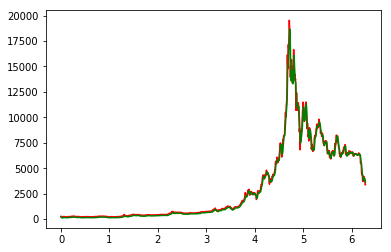

In [17]:
import math
t = np.linspace(0, 2*math.pi, 1425)
plt.plot(t, sc.inverse_transform(y_train),'r')
plt.plot(t,train_p,'g')
plt.show()

## Test fit

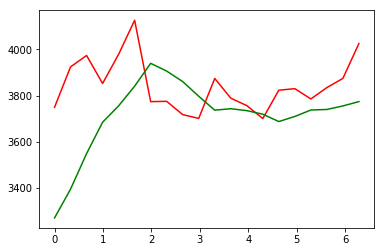

In [18]:
t = np.linspace(0, 2*math.pi, 20)
plt.plot(t, sc.inverse_transform(y_test),'r')
plt.plot(t,test_p,'g')
plt.show()

Seems like the model is overfitting, we can add dropout and gradient clipping to improve results. Lets look at second architecture.

## Bidirectional LSTM Model

In [19]:
# define model
bi_model = tf.keras.models.Sequential()
bi_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, activation='relu'), input_shape=(n_steps, 1)))
bi_model.add(tf.keras.layers.Dense(1))
bi_model.compile(optimizer='adam', loss='mse')

In [20]:
bi_model.fit(X_train, y_train, epochs=nb_epochs, verbose=1, validation_data=(X_test, y_test),callbacks=[mc, es])

Train on 1425 samples, validate on 20 samples
Epoch 1/20
1425/1425 [==============================] - 4s 3ms/step - loss: 0.0162 - val_loss: 7.9686e-04

Epoch 00001: saving model to best_model.h5
Epoch 2/20
1425/1425 [==============================] - 2s 1ms/step - loss: 9.5823e-04 - val_loss: 2.4207e-04

Epoch 00002: saving model to best_model.h5
Epoch 3/20
1425/1425 [==============================] - 2s 2ms/step - loss: 8.5319e-04 - val_loss: 1.4291e-04

Epoch 00003: saving model to best_model.h5
Epoch 4/20
1425/1425 [==============================] - 2s 2ms/step - loss: 7.5895e-04 - val_loss: 1.4017e-04

Epoch 00004: saving model to best_model.h5
Epoch 5/20
1425/1425 [==============================] - 2s 1ms/step - loss: 7.2196e-04 - val_loss: 1.8895e-04

Epoch 00005: saving model to best_model.h5
Epoch 6/20
1425/1425 [==============================] - 2s 1ms/step - loss: 7.0762e-04 - val_loss: 1.8975e-04

Epoch 00006: saving model to best_model.h5
Epoch 7/20
1425/1425 [============

In [21]:
# load the saved model
saved_model2 = tf.keras.models.load_model('best_model.h5')
# evaluate the model
train_loss = saved_model2.evaluate(X_train, y_train, verbose=0)
test_loss = saved_model2.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_loss, test_loss))

Train: 0.000, Test: 0.000


## Inference

In [22]:
train_predictions = saved_model2.predict(X_train)
test_predictions = saved_model2.predict(X_test)

In [23]:
train_p = sc.inverse_transform(train_predictions)
test_p = sc.inverse_transform(test_predictions)

## Training fit

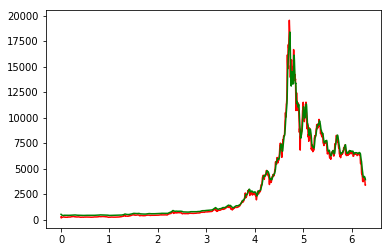

In [24]:
import math
t = np.linspace(0, 2*math.pi, 1425)
plt.plot(t, sc.inverse_transform(y_train),'r')
plt.plot(t,train_p,'g')
plt.show()

## Test fit

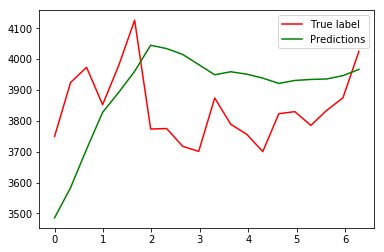

In [25]:
t = np.linspace(0, 2*math.pi, 20)
plt.plot(t, sc.inverse_transform(y_test),'r', label="True label")
plt.plot(t,test_p,'g', label="Predictions")
plt.legend()
plt.show()

## Encoder Decoder Model For Multiple Predictions

### Data Processing

First we need to prepare the data in such a way that multiple steps can go in as input and multiple steps can come as output.

In [26]:
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [27]:
# hyperparameters
n_steps_out = 3

In [40]:
#Prepare batches bs*seq_len*1
X_train,y_train = split_sequence(training_set, n_steps, n_steps_out)
print(X_train.shape, y_train.shape)
X_test, y_test = split_sequence(test_set, n_steps, n_steps_out)
print(X_test.shape, y_test.shape)

(1423, 10, 1) (1423, 3, 1)
(18, 10, 1) (18, 3, 1)


In [41]:
# define model
ed_model = tf.keras.models.Sequential()
ed_model.add(tf.keras.layers.LSTM(100, activation='relu', input_shape=(n_steps, 1)))
ed_model.add(tf.keras.layers.RepeatVector(n_steps_out))
ed_model.add(tf.keras.layers.LSTM(100, activation='relu', return_sequences=True))
ed_model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1)))
ed_model.compile(optimizer='adam', loss='mse')

In [42]:
nb_epochs = 50

In [43]:
history = ed_model.fit(X_train, y_train, epochs=nb_epochs, verbose=1, validation_data=(X_test, y_test),callbacks=[mc, es])

Train on 1423 samples, validate on 18 samples
Epoch 1/50
1423/1423 [==============================] - 5s 3ms/step - loss: 0.0253 - val_loss: 0.0038

Epoch 00001: saving model to best_model.h5
Epoch 2/50
1423/1423 [==============================] - 2s 1ms/step - loss: 0.0035 - val_loss: 5.8966e-04

Epoch 00002: saving model to best_model.h5
Epoch 3/50
1423/1423 [==============================] - 2s 1ms/step - loss: 0.0015 - val_loss: 4.0231e-04

Epoch 00003: saving model to best_model.h5
Epoch 4/50
1423/1423 [==============================] - 2s 1ms/step - loss: 0.0014 - val_loss: 3.5216e-04

Epoch 00004: saving model to best_model.h5
Epoch 5/50
1423/1423 [==============================] - 2s 1ms/step - loss: 0.0010 - val_loss: 5.5425e-04

Epoch 00005: saving model to best_model.h5
Epoch 6/50
1423/1423 [==============================] - 2s 1ms/step - loss: 0.0012 - val_loss: 2.2760e-04

Epoch 00006: saving model to best_model.h5
Epoch 7/50
1423/1423 [==============================] - 2s

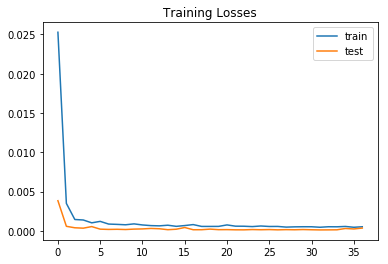

In [44]:
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title("Training Losses")
plt.show()

### Inference For test set

In [49]:
test_predictions = ed_model.predict(X_test)
test_predictions.shape

(18, 3, 1)

In [50]:
y_pred = test_predictions[:,2,:]

In [51]:
y_true = y_test[:,2,:]
y_true.shape

(18, 1)

In [52]:
y_pred.shape

(18, 1)

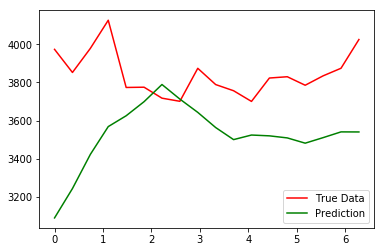

In [53]:
t = np.linspace(0, 2*math.pi, 18)
plt.plot(t, sc.inverse_transform(y_true),'r', label="True Data")
plt.plot(t,sc.inverse_transform(y_pred),'g', label = "Prediction")
plt.legend()
plt.show()

## Visualize the model

In [68]:
ed_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 100)               40800     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 3, 100)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 3, 100)            80400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 3, 1)              101       
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________
